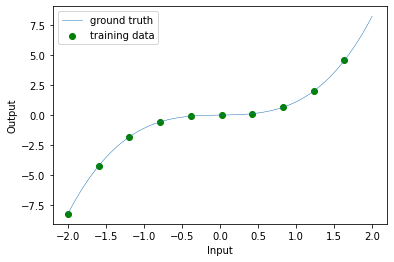

In [6]:
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt

x = jnp.linspace(-2, 2, 100)
y = (x**3 + 0.1 * x)

x_train = x[::10].reshape(-1, 1)
y_train = y[::10].reshape(-1, 1)

plt.plot(x, y, lw=0.5, label="ground truth")
plt.scatter(x_train, y_train, c="g", label="training data")
plt.xlabel("Input")
plt.ylabel("Output")
plt.legend()

In [2]:
import haiku as hk
import optax

def mlp_fn(x: jnp.array) -> jnp.array:
    x = jax.nn.tanh(hk.Linear(20)(x))
    x = hk.Linear(1)(x)
    
    return x

def resnet_fn(inputs: jnp.array) -> jnp.array:
    for _ in range(3):
        outputs = mlp_fn(inputs) + inputs

    return outputs

resnet = hk.without_apply_rng(hk.transform(resnet_fn))
opt = optax.adam(1e-2)

params = resnet.init(jax.random.PRNGKey(42), x_train[0])
opt_state = opt.init(params)

def resnet_loss(params: hk.Params, x: jnp.array, y: jnp.array) -> float:
    loss = jnp.mean((resnet.apply(params, x) - y)**2)
    return loss

@jax.jit
def resnet_update(params: hk.Params, opt_state: optax.OptState, x: jnp.array, y: jnp.array):
    loss, grads = jax.value_and_grad(resnet_loss)(params, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss

for i in range(1000):
    params, opt_state, loss = resnet_update(params, opt_state, x_train, y_train)

    if i % 100 == 0:
        print(f"Loss: {loss:.4f}")

Loss: 8.6380
Loss: 1.5197
Loss: 0.6115
Loss: 0.0772
Loss: 0.0230
Loss: 0.0059
Loss: 0.0022
Loss: 0.0013
Loss: 0.0009
Loss: 0.0007


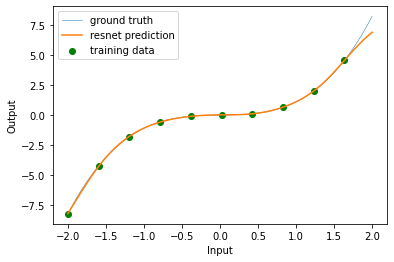

In [3]:
y_pred_resnet = resnet.apply(params, x.reshape(-1, 1)).reshape(-1)

plt.plot(x, y, lw=0.5, label="ground truth")
plt.plot(x, y_pred_resnet, label="resnet prediction")
plt.scatter(x_train, y_train, c="g", label="training data")
plt.xlabel("Input")
plt.ylabel("Output")
plt.legend()

In [4]:
from jax.experimental.ode import odeint

mlp = hk.without_apply_rng(hk.transform(mlp_fn))
opt = optax.adam(1e-2)

params = mlp.init(jax.random.PRNGKey(42), jnp.hstack([x_train[0], [0]]))
opt_state = opt.init(params)

def nn_dynamics(x, time, params):
    state_and_time = jnp.hstack([x, jnp.array(time)])
    return mlp.apply(params, state_and_time)

def odenet(params, x):
    start_and_end_times = jnp.array([0., 1.])
    _, final_state = odeint(nn_dynamics, x, start_and_end_times, params)
    return final_state

def odenet_loss(params, x, y):
    y_pred = jax.vmap(odenet, in_axes=(None, 0))(params, x)
    loss = jnp.mean((y_pred - y)**2)
    return loss

@jax.jit
def odenet_update(params, opt_state, x, y):
    loss, grads = jax.value_and_grad(odenet_loss)(params, x, y)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state, loss

for i in range(1000):
    params, opt_state, loss = odenet_update(params, opt_state, x_train, y_train)

    if i % 100 == 0:
        print(f"Loss: {loss:.4f}")
    



Loss: 5.9858
Loss: 0.7228
Loss: 0.0015
Loss: 0.0009
Loss: 0.0006
Loss: 0.0004
Loss: 0.0003
Loss: 0.0002
Loss: 0.0001
Loss: 0.0001


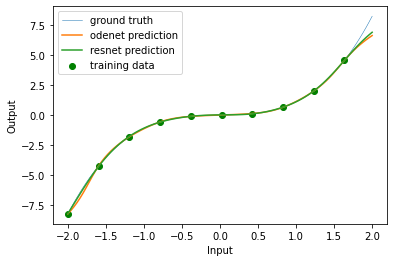

In [5]:

y_pred_odenet = jax.vmap(odenet, in_axes=(None, 0))(params, x.reshape(-1, 1)).reshape(-1)

plt.plot(x, y, lw=0.5, label="ground truth")
plt.plot(x, y_pred_odenet, label="odenet prediction")
plt.plot(x, y_pred_resnet, label="resnet prediction")
plt.scatter(x_train, y_train, c="g", label="training data")
plt.xlabel("Input")
plt.ylabel("Output")
plt.legend()

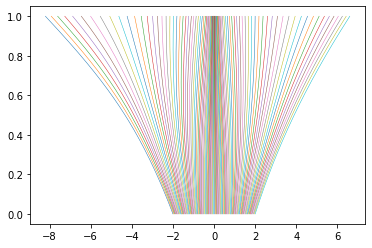

In [8]:
@jax.jit
def odenet_times(params, x, times):
    def dynamics_fn(state, t, params):
        return mlp.apply(params, jnp.hstack([state, t]))
    
    return odeint(dynamics_fn, x, times, params)

times = jnp.linspace(0.,l1., 200)

for i in x:
    plt.plot(odenet_times(params, i, times), times, lw=0.5)